# EIS metadata validation script
Used to validate Planon output with spreadsheet input

## 1. Data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read data. There are two datasets: Planon and Master. The latter is the EIS data nomencalture that was created. Master is made up of two subsets: loggers and meters. Loggers are sometimes called controllers and meters are sometimes called sensors. In rare cases meters or sensors are also called channels.

In [2]:
planon=pd.read_excel('Data Loggers.xlsx',index_col = 'Code')
master_loggerscontrollers = pd.read_csv('LoggersControllers.csv', index_col = 'Asset Code')
master_meterssensors = pd.read_csv('MetersSensors.csv', encoding = 'macroman', index_col = 'Asset Code')

Unify index, caps everything and strip of trailing spaces.

In [7]:
planon.index=[str(i).upper().strip() for i in planon.index]
master_loggerscontrollers.index=[str(i).upper().strip() for i in master_loggerscontrollers.index]
master_meterssensors.index=[str(i).upper().strip() for i in master_meterssensors.index]

Drop duplicates (shouldn't be any)

In [8]:
planon.drop_duplicates(inplace=True)
master_loggerscontrollers.drop_duplicates(inplace=True)
master_meterssensors.drop_duplicates(inplace=True)

Split Planon import into loggers and meters  
Drop duplicates (shouldn't be any)

In [9]:
# Split the Planon file into 2, one for loggers & controllers, and one for meters & sensors.
planon_loggerscontrollers = planon.loc[(planon['Classification Group'] == 'EN.EN4 BMS Controller') | (planon['Classification Group'] == 'EN.EN1 Data Logger')]
planon_meterssensors = planon.loc[(planon['Classification Group'] == 'EN.EN2 Energy Meter') | (planon['Classification Group'] == 'EN.EN3 Energy Sensor')]
planon_loggerscontrollers.drop_duplicates(inplace=True)
planon_meterssensors.drop_duplicates(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index unique? show number of duplicates in index

In [10]:
len(planon_loggerscontrollers.index[planon_loggerscontrollers.index.duplicated()])

0

In [11]:
len(planon_meterssensors.index[planon_meterssensors.index.duplicated()])

538

Meters are not unique. This is becasue of the spaces served. This is ok for now, we will deal with duplicates at the comparison stage. Same is true for loggers - in the unlikely event that there are duplicates in the future.

In [12]:
planon_meterssensors.head(3)

,BuildingNo.,Building,Locations.Space.Space number,Space Name,Additional Location Info,Description,Classification Group,Record,HVAC Ref,Element Description,...,Logger MAC Address,Logger SIM,Meter Pulse Value,Meter Units,Meter Capacity,Network Point ID,Tenant Meter.Name,Fiscal Meter.Name,EIS Space.Space number,Utility Type.Name
MC046-L08/M001,MC046,Bowland Main,NaN,NaN,NaN,Bowland Main Flat 15,EN.EN2 Energy Meter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN
MC046-L08/M001,MC046,Bowland Main,D80,Lobby,NaN,Bowland Main Flat 15,EN.EN2 Energy Meter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN
MC046-L08/M001,MC046,Bowland Main,D81,.,NaN,Bowland Main Flat 15,EN.EN2 Energy Meter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN


## 2. Validation

Create list of all buildings present in Planon export. These are buildings to check the data against from Master.

In [13]:
buildings=set(planon_meterssensors['BuildingNo.'])
buildings

{'MC046', 'MC063', 'MC071'}

### 2.1. Meters

Create dataframe slice for validation from `master_meterssensors` where the only the buildings located in `buildings` are contained. Save this new slice into `master_meterssensors_for_validation`. This is done by creating sub-slices of the dataframe for each building, then concatenating them all together.

In [14]:
master_meterssensors_for_validation = \
    pd.concat([master_meterssensors.loc[master_meterssensors['Building Code'] == building] \
           for building in buildings])
master_meterssensors_for_validation.head(2)

,Logger Asset Code,Description,Make,Model,Meter Units,Meter Pulse Value,Classification Group,Logger Channel,Utility Type,??,...,Building Code,Building Name,Space,Additional Location Info,Tenant meter,Fiscal meter,Parent meter,Child meters,Communications type,Electrical panel ID
MC063-B01/C1,{54561EAD-15A2-4A32-9DAC-ECD49A2F7506},Virtual CNC 1,NaN,NaN,NaN,NaN,Energy sensor,C1,NaN,NaN,...,MC063,Slaidburn House,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
MC063-B01/D1,{54561EAD-15A2-4A32-9DAC-ECD49A2F7506},VT Pump 1 En,NaN,NaN,NaN,NaN,Energy sensor,D1,NaN,NaN,...,MC063,Slaidburn House,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [15]:
#alternative method
master_meterssensors_for_validation2 = \
    master_meterssensors[master_meterssensors['Building Code'].isin(buildings)]
master_meterssensors_for_validation2.head(2)

,Logger Asset Code,Description,Make,Model,Meter Units,Meter Pulse Value,Classification Group,Logger Channel,Utility Type,??,...,Building Code,Building Name,Space,Additional Location Info,Tenant meter,Fiscal meter,Parent meter,Child meters,Communications type,Electrical panel ID
MC071-B01/C1,{B9940A04-170E-4DBA-A49A-27721AC37F8B},Virtual CNC 1,NaN,NaN,NaN,NaN,Energy sensor,C1,NaN,NaN,...,MC071,Furness College,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
MC071-B01/D1,{B9940A04-170E-4DBA-A49A-27721AC37F8B},PHX No1 Control Valve,NaN,NaN,NaN,NaN,Energy sensor,D1,NaN,NaN,...,MC071,Furness College,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Planon sensors are not unique because of the spaces served convention in the two data architectures. The Planon architecture devotes a new line for each space served - hence the not unique index. The Master architecture lists all the spaces only once, as a list, therefore it has a unique index. We will need to take this into account and create matching dataframe out of planon for comparison, with a unique index.

In [16]:
len(master_meterssensors_for_validation)

1401

In [17]:
len(planon_meterssensors)-len(planon_meterssensors.index[planon_meterssensors.index.duplicated()])

1354

Sort datasets after index for easier comparison.

In [18]:
master_meterssensors_for_validation.sort_index(inplace=True)
planon_meterssensors.sort_index(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### 2.1.1 Slicing of meters to  only certain columns of comparison

In [19]:
planon_meterssensors.T

,MC046-B01/A1,MC046-B01/A101,MC046-B01/A2,MC046-B01/A3,MC046-B01/C1,MC046-B01/D10,MC046-B01/D11,MC046-B01/D12,MC046-B01/D13,MC046-B01/D14,...,MC071-L15/M003,MC071-L15/M004,MC071-L15/M004,MC071-L15/M005,MC071-L15/M005,MC071-L16/M001,MC071-L16/M002,MC071-L17/M001,MC071-L17/M002,MC071-L17/M003
BuildingNo.,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,...,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071
Building,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,...,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College
Locations.Space.Space number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,A0,A0,NaN,A0,NaN,NaN,NaN,NaN,NaN,NaN
Space Name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Whole Building,Whole Building,NaN,Whole Building,NaN,NaN,NaN,NaN,NaN,NaN
Additional Location Info,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,Learning Zone - Zone 1 Temp,Outside air temperature,Learning Zone - Zone 2 Temp,Learning Zone - Zone 3 Temp,Virtual CNC 1,Office VT valve,P3 Enable 2RM,P4 Enable 2RM,DHW Systems 4RM,DHW 1 system 4-20Ma,...,Furness College,Furness College,Furness College,Furness College Immersion heater,Furness College Immersion heater,Santander Bank,NaN,LUSU Living,NOK,LUSU Living
Classification Group,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,...,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter
Record,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HVAC Ref,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Element Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
master_meterssensors_for_validation.T

,MC046-B01/A1,MC046-B01/A101,MC046-B01/A2,MC046-B01/A3,MC046-B01/C1,MC046-B01/D10,MC046-B01/D11,MC046-B01/D12,MC046-B01/D13,MC046-B01/D14,...,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN
Logger Asset Code,{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0501987F8800,NaN
Description,Learning Zone - Zone 1 Temp,Outside air temperature,Learning Zone - Zone 2 Temp,Learning Zone - Zone 3 Temp,Virtual CNC 1,Office VT valve,P3 Enable 2RM,P4 Enable 2RM,DHW Systems 4RM,DHW 1 system 4-20Ma,...,NaN,NaN,DB C1 NW,DB C2 NW,DB B1 NW,DB B2 NW,Landlords,Flat 1,LUSU - Housing,NaN
Make,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Danfoss,BU.G.I (meters) Ltd.,NaN,NaN,Selec,Selec,Selec,Ri Meter,NaN,NaN
Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,INFOCAL 8,608819,NaN,NaN,MFM 384,MFM 384,MFM384,CT-2EA,NaN,NaN
Meter Units,Degrees Celsius,Degrees Celsius,Degrees Celsius,Degrees Celsius,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Meter Pulse Value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Classification Group,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,...,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter
Logger Channel,A1,A101,A2,A3,C1,D10,D11,D12,D13,D14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
Utility Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DH,Natural Gas,Electricity,Electricity,Electricity,Electricity,Electricity,Electricity,NaN,Water
??,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create dictionary that maps Planon column names onto Master.  
  
From Nicola:  
- Code (Asset Code)  
- Description
- EIS ID (Channel)
- Utility Type
- Fiscal Meter
- Tenant Meter

`Building code` and `Building name` are implicitly included. `Logger Serial Number`, `IP` or `MAC` would be essential to include, as well as `Make` and `Model`. `Additional Location Info` is not essnetial but would be useful to have. Locations (`Locations.Space.Space number` and `Space Name`) are included in the Planon export - but this is their only viable data source, therefore are not validated against.

In [21]:
#Planon:Master
meters_match_dict={
      "BuildingNo.":"Building Code",
      "Building":"Building Name",
      "Description":"Description",
      "EIS ID":"Logger Channel",
      "Tenant Meter.Name":"Tenant meter",
      "Fiscal Meter.Name":"Fiscal meter"
      }

Filter both dataframes based on these new columns. Then remove duplicates. Currently, this leads to loss of information of spaces served, but also a unique index for the Planon dataframe, therefore bringing the dataframes closer to each other. When including spaces explicitly in the comparison (if we want to - or just trust the  Planon space mapping), this needs to be modified.

In [22]:
master_meterssensors_for_validation_filtered=master_meterssensors_for_validation[list(meters_match_dict.values())]
planon_meterssensors_filtered=planon_meterssensors[list(meters_match_dict.keys())]

In [23]:
master_meterssensors_for_validation_filtered.head(2)

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/A1,MC046,Bowland Main,Learning Zone - Zone 1 Temp,A1,0.0,0.0
MC046-B01/A101,MC046,Bowland Main,Outside air temperature,A101,0.0,0.0


In [24]:
planon_meterssensors_filtered.head(2)

,BuildingNo.,Building,Description,EIS ID,Tenant Meter.Name,Fiscal Meter.Name
MC046-B01/A1,MC046,Bowland Main,Learning Zone - Zone 1 Temp,A1,No,No
MC046-B01/A101,MC046,Bowland Main,Outside air temperature,A101,No,No


Unify headers, drop duplicates (bear the mind the spaces argument, this where it needs to be brought back in in the future!).

In [25]:
planon_meterssensors_filtered.columns=[meters_match_dict[i] for i in planon_meterssensors_filtered]

In [26]:
planon_meterssensors_filtered.drop_duplicates(inplace=True)
master_meterssensors_for_validation_filtered.drop_duplicates(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [27]:
planon_meterssensors_filtered.head(2)

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/A1,MC046,Bowland Main,Learning Zone - Zone 1 Temp,A1,No,No
MC046-B01/A101,MC046,Bowland Main,Outside air temperature,A101,No,No


Fiscal/Tenant meter name needs fixing from Yes/No and 1/0.

In [28]:
planon_meterssensors_filtered['Fiscal meter']=planon_meterssensors_filtered['Fiscal meter'].isin(['Yes'])
planon_meterssensors_filtered['Tenant meter']=planon_meterssensors_filtered['Tenant meter'].isin(['Yes'])
master_meterssensors_for_validation_filtered['Fiscal meter']=master_meterssensors_for_validation_filtered['Fiscal meter'].isin([1])
master_meterssensors_for_validation_filtered['Tenant meter']=master_meterssensors_for_validation_filtered['Tenant meter'].isin([1])

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [29]:
master_meterssensors_for_validation_filtered.head(2)

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/A1,MC046,Bowland Main,Learning Zone - Zone 1 Temp,A1,False,False
MC046-B01/A101,MC046,Bowland Main,Outside air temperature,A101,False,False


In [30]:
planon_meterssensors_filtered.head(2)

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/A1,MC046,Bowland Main,Learning Zone - Zone 1 Temp,A1,False,False
MC046-B01/A101,MC046,Bowland Main,Outside air temperature,A101,False,False


Cross-check missing meters

In [32]:
a=np.sort(list(set(planon_meterssensors_filtered.index)))
b=np.sort(list(set(master_meterssensors_for_validation_filtered.index)))
meterssensors_not_in_planon=[]
for i in b:
    if i not in a:
        print(i+',',end=" "),
        meterssensors_not_in_planon.append(i)
print('\n\nMeters in Master, but not in Planon:',
      len(meterssensors_not_in_planon),'/',len(b),':',
      round(len(meterssensors_not_in_planon)/len(b)*100,3),'%')

MC046-L07/M001, MC046-L07/M002, MC046-L07/M003, MC071-L08/M001, MC071-L08/M004, NAN, 

Meters in Master, but not in Planon: 6 / 1352 : 0.444 %


In [33]:
a=np.sort(list(set(planon_meterssensors_filtered.index)))
b=np.sort(list(set(master_meterssensors_for_validation_filtered.index)))
meterssensors_not_in_master=[]
for i in a:
    if i not in b:
        print(i+',',end=" "),
        meterssensors_not_in_master.append(i)
print('\n\nMeters in Planon, not in Master:',
      len(meterssensors_not_in_master),'/',len(a),':',
      round(len(meterssensors_not_in_master)/len(a)*100,3),'%')

MC046-L08/M001, MC046-L08/M002, MC046-L08/M003, MC071-L09/M001, MC071-L09/M004, 

Meters in Planon, not in Master: 5 / 1351 : 0.37 %


Check for duplicates in index, but not duplicates over the entire row

In [34]:
print(len(planon_meterssensors_filtered.index))
print(len(set(planon_meterssensors_filtered.index)))
print(len(master_meterssensors_for_validation_filtered.index))
print(len(set(master_meterssensors_for_validation_filtered.index)))

1351
1351
1391
1352


In [35]:
master_meterssensors_for_validation_filtered[master_meterssensors_for_validation_filtered.index.duplicated()]

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/I1,MC046,Bowland Main,Mod 1 - 8Ao,i1,False,False
MC046-B01/I2,MC046,Bowland Main,Pressurisation Unit,I2,False,False
MC046-B01/I3,MC046,Bowland Main,Mod 3 - 8Ao,i3,False,False
MC046-B01/I4,MC046,Bowland Main,Mod 4 - 8Ui,i4,False,False
MC046-B01/I5,MC046,Bowland Main,Mod 5 - 8Ui,i5,False,False
MC046-B01/I6,MC046,Bowland Main,Cal 1 18kw On,I6,False,False
MC046-B01/I7,MC046,Bowland Main,Cal 2 45KW,I7,False,False
MC046-B01/I8,MC046,Bowland Main,P1 Flow switch,I8,False,False
MC046-B01/O1,MC046,Bowland Main,Alarm Route 1,o1,False,False
MC046-B01/O2,MC046,Bowland Main,Heating,O2,False,False


The duplicates are the `nan`s. Remove these for now. Could revisit later to do an index-less comparison, only over row contents.

In [66]:
good_index=[i for i in master_meterssensors_for_validation_filtered.index if str(i).lower().strip()!='nan']
master_meterssensors_for_validation_filtered=master_meterssensors_for_validation_filtered.loc[good_index]
master_meterssensors_for_validation_filtered.drop_duplicates(inplace=True)

In [69]:
len(planon_meterssensors_filtered)

1351

In [70]:
len(master_meterssensors_for_validation_filtered)

1375

Do comparison only on common indices. Need to revisit and identify the cause missing meters, both ways (5 Planon->Meters and 30 Meters->Planon in this example).

In [71]:
comon_index=list(set(master_meterssensors_for_validation_filtered.index).intersection(set(planon_meterssensors_filtered.index)))

In [73]:
len(comon_index)

1346

In [76]:
master_meterssensors_for_validation_intersected=master_meterssensors_for_validation_filtered.loc[comon_index].sort_index()
planon_meterssensors_intersected=planon_meterssensors_filtered.loc[comon_index].sort_index()

In [77]:
len(master_meterssensors_for_validation_intersected)

1370

In [78]:
len(planon_meterssensors_intersected)

1346

Still have duplicate indices. For now we just drop and keep the first.

In [80]:
master_meterssensors_for_validation_intersected = master_meterssensors_for_validation_intersected[~master_meterssensors_for_validation_intersected.index.duplicated(keep='first')]

In [81]:
master_meterssensors_for_validation_intersected.head(2)

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/A1,MC046,Bowland Main,Learning Zone - Zone 1 Temp,A1,False,False
MC046-B01/A101,MC046,Bowland Main,Outside air temperature,A101,False,False


In [82]:
planon_meterssensors_intersected.head(2)

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/A1,MC046,Bowland Main,Learning Zone - Zone 1 Temp,A1,False,False
MC046-B01/A101,MC046,Bowland Main,Outside air temperature,A101,False,False


#### 2.1.2. Primitive comparison

In [83]:
planon_meterssensors_intersected==master_meterssensors_for_validation_intersected

,Building Code,Building Name,Description,Logger Channel,Tenant meter,Fiscal meter
MC046-B01/A1,True,True,True,True,True,True
MC046-B01/A101,True,True,True,True,True,True
MC046-B01/A2,True,True,True,True,True,True
MC046-B01/A3,True,True,True,True,True,True
MC046-B01/C1,True,True,True,True,True,True
MC046-B01/D10,True,True,True,True,True,True
MC046-B01/D11,True,True,True,True,True,True
MC046-B01/D12,True,True,True,True,True,True
MC046-B01/D13,True,True,True,True,True,True
MC046-B01/D14,True,True,True,True,True,True


In [84]:
np.all(planon_meterssensors_intersected==master_meterssensors_for_validation_intersected)

False

#### 2.1.3. Horizontal comparison

Number of cells matching

In [85]:
(planon_meterssensors_intersected==master_meterssensors_for_validation_intersected).sum()

Building Code     1346
Building Name     1346
Description       1309
Logger Channel    1157
Tenant meter      1346
Fiscal meter      1346
dtype: int64

Percentage matching

In [86]:
(planon_meterssensors_intersected==master_meterssensors_for_validation_intersected).sum()/\
len(planon_meterssensors_intersected)*100

Building Code     100.000000
Building Name     100.000000
Description        97.251114
Logger Channel     85.958395
Tenant meter      100.000000
Fiscal meter      100.000000
dtype: float64

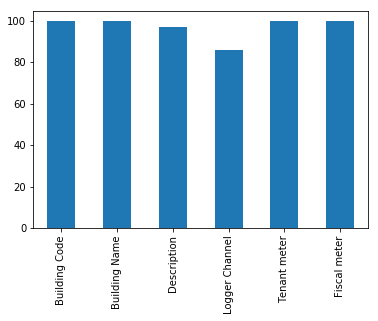

In [87]:
((planon_meterssensors_intersected==master_meterssensors_for_validation_intersected).sum()/\
len(planon_meterssensors_intersected)*100).plot(kind='bar')

#### 2.1.4. Vertical comparison

In [88]:
df=pd.DataFrame((planon_meterssensors_intersected.T==master_meterssensors_for_validation_intersected.T).sum())
df

,0
MC046-B01/A1,6
MC046-B01/A101,6
MC046-B01/A2,6
MC046-B01/A3,6
MC046-B01/C1,6
MC046-B01/D10,6
MC046-B01/D11,6
MC046-B01/D12,6
MC046-B01/D13,6
MC046-B01/D14,6


In [89]:
df=pd.DataFrame((planon_meterssensors_intersected.T==master_meterssensors_for_validation_intersected.T).sum()/\
len(planon_meterssensors_intersected.T)*100)
df[df[0]<100]

,0
MC046-B01/F48,83.333333
MC046-B01/F49,83.333333
MC046-B01/F50,83.333333
MC046-B01/F51,83.333333
MC046-B01/I1,83.333333
MC046-B01/I2,83.333333
MC046-B01/I25,83.333333
MC046-B01/I29,83.333333
MC046-B01/I3,83.333333
MC046-B01/I4,83.333333


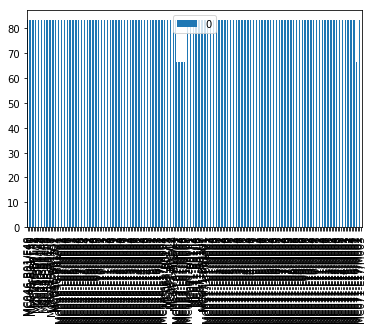

In [90]:
df[df[0]<100].plot(kind='bar')

#### 2.1.5. Smart(er) comparison

Not all of the dataframe matches. Let us do some basic string formatting, maybe that helps.

In [91]:
sum(planon_meterssensors_intersected['Description']!=master_meterssensors_for_validation_intersected['Description'])

37

In [92]:
planon_meterssensors_intersected['Description']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in planon_meterssensors_intersected['Description'].values]
master_meterssensors_for_validation_intersected['Description']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in master_meterssensors_for_validation_intersected['Description'].values]

In [93]:
sum(planon_meterssensors_intersected['Description']!=master_meterssensors_for_validation_intersected['Description'])

17

Some errors fixed, some left. Let's see which ones. These are either:  
- Wrong duplicate dropped
- Input human erros in the description.
- Actual erros somewhere in the indexing.

In [95]:
for i in planon_meterssensors_intersected[planon_meterssensors_intersected['Description']!=master_meterssensors_for_validation_intersected['Description']].index:
    print(i,'\t\tPlanon:',planon_meterssensors_intersected.loc[i]['Description'],'\t\tMaster:',master_meterssensors_for_validation_intersected.loc[i]['Description'])

MC046-B01/I4 		Planon: mod 4 - 8ui 		Master: p1 b fault
MC046-B01/I7 		Planon: mod 7 - 4ui 		Master: cal 2  45kw
MC046-B01/O1 		Planon: heating 		Master: alarm route 1
MC046-B01/O2 		Planon: heating 		Master: alarm route 2
MC046-B01/O3 		Planon: optimum start stop 3 		Master: alarm route 3
MC063-B01/I3 		Planon: module 3 		Master: shower fans south fault
MC063-B01/L2 		Planon: nan 		Master: 
MC063-B01/L3 		Planon: nan 		Master: 
MC063-B01/L4 		Planon: nan 		Master: 
MC071-B01/I1 		Planon: 16di_module 1 		Master: bar lossney hx03 fault
MC071-B01/I2 		Planon: 8ui_module 2 		Master: bar lossney hx04 fault
MC071-B01/I4 		Planon: toilet extract fan b013 fault 		Master: 4ao_module 4
MC071-B01/I5 		Planon: 8do_module 1 		Master: toilet extract fan c068 fault
MC071-B01/I6 		Planon: 4ui4ao_module 6 		Master: toilet extract fan c047 fault
MC071-B01/I7 		Planon: toilet extract fan b070 fault 		Master: 8ui_module 7
MC071-B01/I8 		Planon: 4ui4ao_module 8 		Master: eco hold off
MC071-B01/O1 		Planon

Let us repeat the exercise for `Logger Channel`. Cross-validate, flag as highly likely error where both mismatch.

In [96]:
sum(planon_meterssensors_intersected['Logger Channel']!=master_meterssensors_for_validation_intersected['Logger Channel'])

189

In [97]:
planon_meterssensors_intersected['Logger Channel']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in planon_meterssensors_intersected['Logger Channel'].values]
master_meterssensors_for_validation_intersected['Logger Channel']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in master_meterssensors_for_validation_intersected['Logger Channel'].values]

In [98]:
sum(planon_meterssensors_intersected['Logger Channel']!=master_meterssensors_for_validation_intersected['Logger Channel'])

0

All errors fixed on logger channels.

In [99]:
for i in planon_meterssensors_intersected[planon_meterssensors_intersected['Logger Channel']!=master_meterssensors_for_validation_intersected['Logger Channel']].index:
    print(i,'\t\tPlanon:',planon_meterssensors_intersected.loc[i]['Logger Channel'],'\t\tMaster:',master_meterssensors_for_validation_intersected.loc[i]['Logger Channel'])

New error percentage:

In [100]:
(planon_meterssensors_intersected!=master_meterssensors_for_validation_intersected).sum()/\
len(planon_meterssensors_intersected)*100

Building Code     0.000000
Building Name     0.000000
Description       1.263001
Logger Channel    0.000000
Tenant meter      0.000000
Fiscal meter      0.000000
dtype: float64

### 2.2. Loggers

In [101]:
master_loggerscontrollers_for_validation = \
    pd.concat([master_loggerscontrollers.loc[master_loggerscontrollers['Building Code'] == building] \
           for building in buildings])
master_loggerscontrollers_for_validation.head(2)

,Building Code,Building Name,Space,Description,Classification Group,Make,Model,Logger Serial Number,Logger Mac Address,Logger Ip Address,Logger Modem Serial Number,Logger Sim,Network Point Id,Logger Upstream Comms Target,Additional Location Info
MC063-L01,MC063,Slaidburn House,Plant Room,Data logger: Slaidburn House,Data logger,Enercom,Multilog G2,050198829500,00-50-C2-2C-3E-53,10.23.11.101,NaN,NaN,NaN,NaN,Plant Room
MC063-L02,MC063,Slaidburn House,Plant Room,Data logger: Slaidburn House,Data logger,Enercom,Multilog G2,0501E4369600,NaN,NaN,NaN,NaN,NaN,NaN,Plant Room


In [102]:
len(master_loggerscontrollers_for_validation)

41

In [103]:
len(planon_loggerscontrollers)-len(planon_loggerscontrollers.index[planon_loggerscontrollers.index.duplicated()])

36

In [104]:
master_loggerscontrollers_for_validation.sort_index(inplace=True)
planon_loggerscontrollers.sort_index(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [105]:
planon_loggerscontrollers.T

,MC046-B01,MC046-L02,MC046-L05,MC046-L06,MC046-L07,MC046-L08,MC046-L09,MC046-L10,MC046-L11,MC046-L12,...,MC071-L08,MC071-L09,MC071-L10,MC071-L11,MC071-L12,MC071-L13,MC071-L14,MC071-L15,MC071-L16,MC071-L17
BuildingNo.,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,...,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071
Building,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,...,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College
Locations.Space.Space number,NaN,A0,Bt6,Bt6,D86,D86,D64,D64,D17,D44,...,A0,A0,A0,A0,LG11,LG11,NaN,PL2,A048,PL1
Space Name,NaN,Whole Building,Plant Room,Plant Room,Lobby,Lobby,Landing,Landing,Lobby,Lobby,...,Whole Building,Whole Building,Whole Building,Whole Building,Pizzetta Republic,Pizzetta Republic,NaN,Substation No.4,LUSU Living,Plant Room
Additional Location Info,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,BMS Controller: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,...,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College - The Venue,Data logger: Furness College - Sub Station No.4,Data logger: Furness College - LUVU Office,Data logger: Furness College - Green Room
Classification Group,EN.EN4 BMS Controller,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,...,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger
Record,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HVAC Ref,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Element Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
master_loggerscontrollers_for_validation.T

,MC046-B01,MC046-L01,MC046-L02,MC046-L03,MC046-L04,MC046-L05,MC046-L06,MC046-L07,MC046-L08,MC046-L09,...,MC071-L08,MC071-L09,MC071-L10,MC071-L11,MC071-L12,MC071-L13,MC071-L14,MC071-L15,MC071-L16,MC071-L17
Building Code,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,MC046,...,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071,MC071
Building Name,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,Bowland Main,...,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College,Furness College
Space,NaN,Bt6,A0,A0,Bt6,Bt6,Bt6,D86,D86,D64,...,A0,A0,A0,A0,LG11,LG11,NaN,PL2,A048,PL1
Description,BMS Controller: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,Data logger: Bowland Main,...,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College,Data logger: Furness College - The Venue,Data logger: Furness College - Sub Station No.4,Data logger: Furness College - LUVU Office,Data logger: Furness College - Green Room
Classification Group,BMS controller,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,...,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger
Make,Trend,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,...,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom
Model,IQ3xcite96,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,...,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2
Logger Serial Number,{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},NaN,050200C7E200,NaN,NaN,050198895300,050200C41100,0501E3889900,0501FD5E5F00,050200BAC300,...,0502012BA000,0501F883F600,0501F9058600,0501F9076200,050157B41C00,05019891F000,050157C16200,050157AE6600,050198904000,050157AF8400
Logger Mac Address,NaN,NaN,NaN,NaN,00-50-C2-2C-3D-19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00-50-C2-2C-3D-15,00-50-C2-2C-3D-BF
Logger Ip Address,bo-bms01-bt6a.bms.local,NaN,NaN,NaN,10.23.13.103,NaN,NaN,NaN,NaN,NaN,...,10.23.10.207,10.23.10.207,10.23.10.207,10.23.??.??,NaN,NaN,NaN,NaN,10.23.9.71,10.23.10.202


Create dictionary that maps Planon column names onto Master.  
  
From Nicola:  
- EIS ID (Serial Number)
- Make
- Model
- Description
- Code (Asset Code)
- Building Code

`Building code` and `Building name` are implicitly included. `Logger IP` or `MAC` would be essential to include, as well as `Make` and `Model`. `Additional Location Info` is not essnetial but would be useful to have. Locations (`Locations.Space.Space number` and `Space Name`) are included in the Planon export - but this is their only viable data source, therefore are not validated against.

In [107]:
#Planon:Master
loggers_match_dict={
      "BuildingNo.":"Building Code",
      "Building":"Building Name",
      "Description":"Description",
      "EIS ID":"Logger Serial Number",
      "Make":"Make",
      "Model":"Model"
      }

In [108]:
master_loggerscontrollers_for_validation_filtered=master_loggerscontrollers_for_validation[list(loggers_match_dict.values())]
planon_loggerscontrollers_filtered=planon_loggerscontrollers[list(loggers_match_dict.keys())]

In [109]:
master_loggerscontrollers_for_validation_filtered.head(2)

,Building Code,Building Name,Description,Logger Serial Number,Make,Model
MC046-B01,MC046,Bowland Main,BMS Controller: Bowland Main,{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},Trend,IQ3xcite96
MC046-L01,MC046,Bowland Main,Data logger: Bowland Main,NaN,Enercom,Multilog G2


In [110]:
planon_loggerscontrollers_filtered.head(2)

,BuildingNo.,Building,Description,EIS ID,Make,Model
MC046-B01,MC046,Bowland Main,BMS Controller: Bowland Main,8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2,Trend,IQ3xcite96
MC046-L02,MC046,Bowland Main,Data logger: Bowland Main,050200C7E200,Enercom,Multilog G2


In [111]:
planon_loggerscontrollers_filtered.columns=[loggers_match_dict[i] for i in planon_loggerscontrollers_filtered]

In [112]:
planon_loggerscontrollers_filtered.drop_duplicates(inplace=True)
master_loggerscontrollers_for_validation_filtered.drop_duplicates(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [113]:
planon_loggerscontrollers_filtered.head(2)

,Building Code,Building Name,Description,Logger Serial Number,Make,Model
MC046-B01,MC046,Bowland Main,BMS Controller: Bowland Main,8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2,Trend,IQ3xcite96
MC046-L02,MC046,Bowland Main,Data logger: Bowland Main,050200C7E200,Enercom,Multilog G2


In [114]:
master_loggerscontrollers_for_validation_filtered.head(2)

,Building Code,Building Name,Description,Logger Serial Number,Make,Model
MC046-B01,MC046,Bowland Main,BMS Controller: Bowland Main,{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},Trend,IQ3xcite96
MC046-L01,MC046,Bowland Main,Data logger: Bowland Main,NaN,Enercom,Multilog G2


In [115]:
a=np.sort(list(set(planon_loggerscontrollers_filtered.index)))
b=np.sort(list(set(master_loggerscontrollers_for_validation_filtered.index)))
loggerscontrollers_not_in_planon=[]
for i in b:
    if i not in a:
        print(i+',',end=" "),
        loggerscontrollers_not_in_planon.append(i)
print('\n\nMeters in Master, but not in Planon:',
      len(loggerscontrollers_not_in_planon),'/',len(b),':',
      round(len(loggerscontrollers_not_in_planon)/len(b)*100,3),'%')

MC046-L01, MC046-L19, 

Meters in Master, but not in Planon: 2 / 38 : 5.263 %


In [116]:
a=np.sort(list(set(planon_loggerscontrollers_filtered.index)))
b=np.sort(list(set(master_loggerscontrollers_for_validation_filtered.index)))
loggerscontrollers_not_in_master=[]
for i in a:
    if i not in b:
        print(i+',',end=" "),
        loggerscontrollers_not_in_master.append(i)
print('\n\nMeters in Planon, not in Master:',
      len(loggerscontrollers_not_in_master),'/',len(a),':',
      round(len(loggerscontrollers_not_in_master)/len(a)*100,3),'%')



Meters in Planon, not in Master: 0 / 36 : 0.0 %


In [117]:
print(len(planon_loggerscontrollers_filtered.index))
print(len(set(planon_loggerscontrollers_filtered.index)))
print(len(master_loggerscontrollers_for_validation_filtered.index))
print(len(set(master_loggerscontrollers_for_validation_filtered.index)))

36
36
38
38


In [118]:
master_loggerscontrollers_for_validation_filtered[master_loggerscontrollers_for_validation_filtered.index.duplicated()]

,Building Code,Building Name,Description,Logger Serial Number,Make,Model


In [119]:
comon_index=list(set(master_loggerscontrollers_for_validation_filtered.index).intersection(set(planon_loggerscontrollers_filtered.index)))

In [120]:
master_loggerscontrollers_for_validation_intersected=master_loggerscontrollers_for_validation_filtered.loc[comon_index].sort_index()
planon_loggerscontrollers_intersected=planon_loggerscontrollers_filtered.loc[comon_index].sort_index()

In [121]:
master_loggerscontrollers_for_validation_intersected.head(2)

,Building Code,Building Name,Description,Logger Serial Number,Make,Model
MC046-B01,MC046,Bowland Main,BMS Controller: Bowland Main,{8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2},Trend,IQ3xcite96
MC046-L02,MC046,Bowland Main,Data logger: Bowland Main,050200C7E200,Enercom,Multilog G2


In [122]:
planon_loggerscontrollers_intersected.head(2)

,Building Code,Building Name,Description,Logger Serial Number,Make,Model
MC046-B01,MC046,Bowland Main,BMS Controller: Bowland Main,8AE84AB9-0098-468B-81FC-C5EDD0B0C0A2,Trend,IQ3xcite96
MC046-L02,MC046,Bowland Main,Data logger: Bowland Main,050200C7E200,Enercom,Multilog G2


In [123]:
planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected

,Building Code,Building Name,Description,Logger Serial Number,Make,Model
MC046-B01,True,True,True,False,True,True
MC046-L02,True,True,True,True,True,True
MC046-L05,True,True,True,False,True,True
MC046-L06,True,True,True,True,True,True
MC046-L07,True,True,True,True,True,True
MC046-L08,True,True,True,True,True,True
MC046-L09,True,True,True,True,True,True
MC046-L10,True,True,True,True,True,True
MC046-L11,True,True,True,True,True,True
MC046-L12,True,True,True,True,True,True


Loggers matching

In [124]:
(planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected).sum()

Building Code           36
Building Name           35
Description             36
Logger Serial Number    28
Make                    36
Model                   36
dtype: int64

Percentage matching

In [125]:
(planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected).sum()/\
len(planon_loggerscontrollers_intersected)*100

Building Code           100.000000
Building Name            97.222222
Description             100.000000
Logger Serial Number     77.777778
Make                    100.000000
Model                   100.000000
dtype: float64

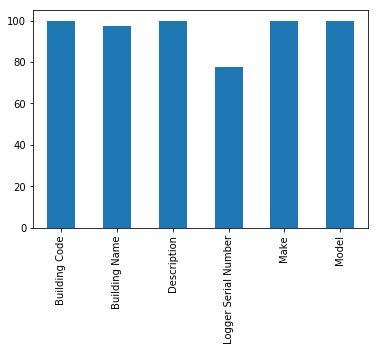

In [126]:
((planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected).sum()/\
len(planon_loggerscontrollers_intersected)*100).plot(kind='bar')

Loggers not matching on `Building Name`.

In [127]:
sum(planon_loggerscontrollers_intersected['Building Name']!=master_loggerscontrollers_for_validation_intersected['Building Name'])

1

In [128]:
planon_loggerscontrollers_intersected['Building Name']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in planon_loggerscontrollers_intersected['Building Name'].values]
master_loggerscontrollers_for_validation_intersected['Building Name']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in master_loggerscontrollers_for_validation_intersected['Building Name'].values]

In [129]:
sum(planon_loggerscontrollers_intersected['Building Name']!=master_loggerscontrollers_for_validation_intersected['Building Name'])

1

That didnt help.

In [130]:
for i in planon_loggerscontrollers_intersected[planon_loggerscontrollers_intersected['Building Name']!=master_loggerscontrollers_for_validation_intersected['Building Name']].index:
    print(i,'\t\tPlanon:',planon_loggerscontrollers_intersected.loc[i]['Building Name'],'\t\tMaster:',master_loggerscontrollers_for_validation_intersected.loc[i]['Building Name'])

MC071-B01 		Planon: furness college 		Master: furness


Follow up with lexical distance comparison. That would flag this as a match.

Loggers not matching on `Serial Number`.

In [131]:
sum(planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number'])

8

In [132]:
planon_loggerscontrollers_intersected['Logger Serial Number']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ').replace('{','').replace('}','') for s in planon_loggerscontrollers_intersected['Logger Serial Number'].values]
master_loggerscontrollers_for_validation_intersected['Logger Serial Number']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ').replace('{','').replace('}','') for s in master_loggerscontrollers_for_validation_intersected['Logger Serial Number'].values]

In [133]:
sum(planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number'])

5

In [134]:
for i in planon_loggerscontrollers_intersected[planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number']].index:
    print(i,'\t\tPlanon:',planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'],'\t\tMaster:',master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number'])

MC046-L05 		Planon: 50198895300 		Master: 050198895300
MC063-L01 		Planon: 50198829500 		Master: 050198829500
MC071-L02 		Planon: 50201286300 		Master: 050201286300
MC071-L05 		Planon: 50201221 		Master: 050201221e00
MC071-L16 		Planon: 50198904000 		Master: 050198904000


Technically the same, but there is a number format error. Compare based on float value, if they match, replace one of them. This needs to be amended, as it will throw `cannot onvert to float` exception if strings are left in from the previous step.

In [135]:
z1=[]
z2=[]    
for i in planon_loggerscontrollers_intersected.index:
    if planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number']:
        if float(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])==\
          float(master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number']):
                z1.append(str(int(float(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number']))))
                z2.append(str(int(float(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number']))))
        else:
            z1.append(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])
            z2.append(master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number'])
    else:
        z1.append(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])
        z2.append(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])
planon_loggerscontrollers_intersected['Logger Serial Number']=z1
master_loggerscontrollers_for_validation_intersected['Logger Serial Number']=z2

In [136]:
for i in planon_loggerscontrollers_intersected[planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number']].index:
    print(i,'\t\tPlanon:',planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'],'\t\tMaster:',master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number'])

New error percentage:

In [137]:
(planon_loggerscontrollers_intersected!=master_loggerscontrollers_for_validation_intersected).sum()/\
len(planon_loggerscontrollers_intersected)*100

Building Code           0.000000
Building Name           2.777778
Description             0.000000
Logger Serial Number    0.000000
Make                    0.000000
Model                   0.000000
dtype: float64

(Bearing in my mind the above, this is technically 0)